# CSCI 3352 Biological Networks, Spring 2021, Prof. Clauset
Submit here: https://canvas.colorado.edu/courses/69236

# Problem Set 3 : Random graph models

***

**Name**: Clayton Schneider

***

This assignment is due on Canvas by **11:55pm on Friday, February 5th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 90 points total, and 15 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Canvas.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

***
## Problem 1 : It's a small world (50 pts total)

We have argued that the mean geodesic distance $\langle \ell \rangle$ between pairs of nodes in an Erdos-Renyi random graph grows like $O(\log n)$. In this question, you will
* use the ER model as a substrate for a numerical experiment to quantify and demonstrate this behavior, and
* investigate the question of how this logarithmic growth depends on a network's edge density parameter $p$.

We'll build up to this experiment in four steps.

### Problem 1-A (10 pts)

The first step in developing the numerical simulation is to write a function that makes *one* measurement of $\langle \ell \rangle$ on a given network $G$.

* Write a function `compute_MGD(G)` that takes as input a network `G` and computes the *mean geodesic path length* (or "mean geodesic distance") as defined in Lecture 2. This function should start with calling the `networkx` function `all_pairs_shortest_path_length()`, which runs an All Pairs Shortest Paths algorithm. You'll need to then process the output of this function correctly in order to compute $\langle \ell \rangle$ the way it is defined in the lecture notes.
* Then apply your function to the graph below and report $\langle \ell \rangle$.

Hint: Because $G(n,p)$ is almost surely not connected, you won't be able to use `networkx`'s function `average_shortest_path_length()`, because it fails on disconnected graphs. You'll need to write your own, in order to handle 0 and $\infty$ distances correctly.

In [2]:
def compute_MGD(G):
    # input : a networkx graph G
    path_lengths = []
    for v in G.nodes():
        distances = nx.single_source_shortest_path_length(G, v)
        for path in distances.values():
            path_lengths.append(path)

    # output: the mean geodesic path length (defined in Lecture 2)      
    return np.mean(path_lengths)

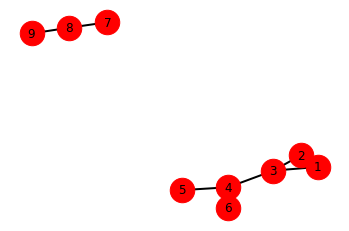

MGD =   1.42


In [3]:
G = nx.Graph([(1,3),(1,2),(2,3),(3,4),(4,5),(4,6),(7,8),(8,9)])
nx.draw_networkx(G,arrows=True,with_labels=True,node_size=600,node_color='r',width=2) # draw it pretty
limits=plt.axis('off')                                                                # turn off axes
plt.show()                                                                            # show me the network!

ellm = compute_MGD(G)
print(f'MGD =  %5.2f' % ellm)

### Problem 1-B (10 pts)

Given a way to measure the $\langle \ell \rangle$ for *one* network, we can jump right to a numerical experiment by choosing $p$ and then generating *one* network from $G(n,p)$ for a variety of choices of $n$, and for each, calculate $\langle \ell \rangle$. We'll visualize the result using a `semilogx` plot. (These results won't be *good*, and so we'll refine them in the next subproblem.)

* Set the target mean degree $c=2$, and use the `fast_gnp_random_graph()` function in `networkx` to generate a $G(n,p)$ network.
* To convincingly show the growth behavior, systematically vary $n$ over a wide range, e.g., choose $n=2^k$ for $k=\{4,5,6,7,8,9,10\}$.
* For each such choice of $n$, generate *one* $G(n,p)$ network, and compute its $\langle \ell \rangle$ using your `compute_MGD()` function.
* Then, produce a single `semilogx` plot that shows how $\langle \ell \rangle$ varies as a function of $n$. (Using a `semilogx` will conveniently make logarithmic functions look linear on the page.)
* Run this experiment a few times, and then comment briefly in the markdown box below what you observe about the stability and smoothness of the trend.

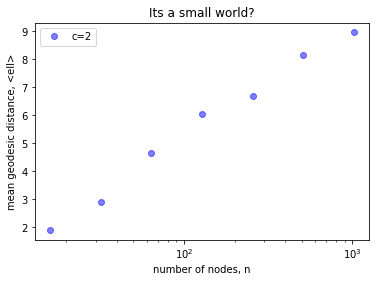

In [4]:
ns = np.logspace(4,10,num=7,base=2)  # number of nodes: 2^{4:10}
ns = ns.astype(int)                  # convert to ints
ellm = []                            # store the MGDs here

##### do not modify above here #####
ellm = []
ns = []
k = [4, 5, 6, 7, 8, 9, 10]
for n in k:
    G = nx.fast_gnp_random_graph(2**n, 2/(2**n - 1))
    ellm.append(compute_MGD(G))
    ns.append(len(G.nodes))
    

##### do not modify below here #####
plt.semilogx(ns, ellm, 'bo', alpha=0.5,label='c=2')
plt.title('Its a small world?')
plt.ylabel('mean geodesic distance, <ell>')
plt.xlabel('number of nodes, n')
plt.legend(loc='upper left');
plt.show()

I was a little biased by my first few iterations - it was nearly a perfect linear/log relationship! But as I continued to run the system, I saw that it's actually not all that stable, and sometimes you'll even have inflection points. In general, it does seem that the MGD grows at log(n). 

### Problem 1-C (10 pts)

Because $G(n,p)$ is a random graph, each $\langle \ell \rangle$ is a *random variable*, meaning that it will fluctuate between different draws from the parameterized model $G(n,p)$. In other words, if we draw a sequence of graphs $G_1,G_2,\dots$ from the model $G(n,p)$, we'll get a sequence of measurements $\langle \ell \rangle_1,\langle \ell \rangle_2,\dots$, each a little different from each other.

To get a *smooth* trend in our plot, we need to get a *good* estimate of $\langle \ell \rangle$ for each choice of $n$. We do this by *averaging* the sequence of measurements $\langle \ell \rangle_1,\langle \ell \rangle_2,\dots$ for each choice of $n$. Averaging generates a better estimate of the mean because it estimates the central value around which the fluctuations occur. Plotting these central tendencies will produce a nicely smooth curve in the final figure for showing the growth of $\langle \ell \rangle(n)$. (This idea is _general_, meaning you can apply it to almost any model that produces a fluctuating signal, because of something called the Central Limit Theorem.)

* Write a function `compute_MGD_Gnp(n,p,rep)` that takes as input the parameters of $G(n,p)$ and a number of *repetions* `rep`, and returns the average MGD over `rep` draws from $G(n,p)$. (This should be a wrapper around your function `compute_MGD()`.)
* Apply your function with `n=256`, `c=2`, and `rep=10`, and report the results.

In [5]:
def compute_MGD_Gnp(n,p,rep):
    # input : a number of nodes 'n', edge density parameter 'p', and number of repetitions 'rep'
    # output: the mean geodesic path length of G(n,p), averaged over 'rep' instances

    ellm = []
    for i in range(rep):
        G = nx.fast_gnp_random_graph(n, p)
        ellm.append(compute_MGD(G))
        
    c = p*(n - 1)
        
    return n, c, rep, np.mean(ellm)

In [6]:
n, c, rep, ellmean = compute_MGD_Gnp(256, 2/255, 10)


##### do not modify below here #####
print(f'[ n={n} | c={c} | reps={rep} ] <ell> = %5.2f' % ellmean)

[ n=256 | c=2.0 | reps=10 ] <ell> =  6.95


### Problem 1-D (20 pts) Putting it all together

* Rewrite your numerical experiment so that it uses `compute_MGD_Gnp()` to compute a *good* estimate of $\langle \ell \rangle$, for each choice of $n$ and $c$.
* Expand your experiment to compute how $\langle \ell \rangle$ grows as a function of $n$, for each of three mean degree values $c=\{2,4,8\}$.
* Use $n=2^k$ for $k=\{4,5,6,7,8,9,10,11,12,13\}$. (This will take a while on your computer; plan accordingly)
* Then, on one figure, plot
  * the three data series from your simulations, and 
  * three *trend lines,* each of the form $b\times \log_{10} n + a$, one for each of the three data series. For each such trend line, choose a value $b$ that puts it visually very close to its data series. You may position these by hand, or by estimation using something like `np.polyfit`.
* Finally, briefly discuss what you see about how $b$ varies with $c$, and give some intuition as to why this behavior makes sense given what we know about the structure of ER graphs.

Hint 1: Separate the code for the experiment from the code for the visualization, so that you can tinker with the latter without having to re-run the former.

Hint 2: Running the full experiment to completion will take a while on your computer (it took 4 hours on mine), so prototype the code and visualization using only a few, smaller values of $n$. Once you have the bugs worked out, then do the full range of $n$ while you sleep/get coffee/go for a hike/etc.


(*5 pts extra credit*) Construct a second plot of $b$ vs. $c$ and describe the functional relationship between the two. To get a good view of it, you may need to consider additional values of $c$.

In [120]:
data = []
cs = [2, 4, 8, 10]
ns = np.square([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

for c in cs:
    ellmeans = []
    for n in ns:
        n, c, rep, ellmean = compute_MGD_Gnp(n,c/(n-1), 1000)
        ellmeans.append(ellmean)
    data.append(ellmeans)

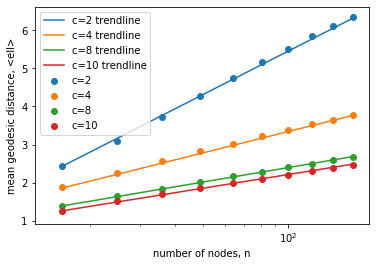

In [162]:
fig = plt.subplot(111)

bs = [1.65, 0.81, 0.55, 0.52]
As = [-1.3, -0.48, -0.25, -0.35]

for i, c in enumerate(cs):
    plt.scatter(ns, data[i], label=f'c={c}')
    plt.plot(ns, [bs[i]*(np.log(n)+As[i]) for n in ns], label=f'c={c} trendline')

fig.set_xscale('log')
plt.ylabel('mean geodesic distance, <ell>')
plt.xlabel('number of nodes, n')
plt.legend()

Text(0, 0.5, 'b values')

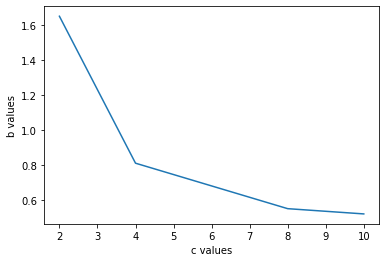

In [165]:
fig2 = plt.subplot(111)
plt.plot(cs, bs)

plt.xlabel('c values')
plt.ylabel('b values')

B is inversely proportional to c. As c reaches higher values, it means that the mean degree is increasing, and the MGD is therefore lesser for higher values of c, and the effects of the size of the network are diminished as c increases. So the slope for our trend plots, b, which describes how quickly the MGD grows as a function of n, is going to be lower and lower as c increases, and the MGD flatlines. When we plot b and c together, this becomes very clear, as it's similar to a logarithmic decay function.

***
***
## Problem 2 : Does this random graph make my $\langle \ell \rangle$ look big? (40 pts)

In this question, you will use the ER and Chung-Lu random graph models as null models to investigate the degree to which edge density and/or degree distributions can *explain* observed patterns in a biological network.

* Go to the [Index of Complex Networks](https://icon.colorado.edu/) (ICON) website, find the **P. pacificus nematode (2013)** entry, and download the `P.pacificus_neural.synaptic_1` network data file from the linked website. This file is in a `graphML` format, which is different from `GML`, but functionally is similar. `networkx` can read both.

### Problem 2-A (10 pts)

To warm up, load the *P. pacificus* network and treat it as a simple graph (edges unweighted and undirected; no multi-edges; no self-loops). Then calculate and report
* number of nodes $n$
* (undirected) edges $m$
* mean degree $\langle k \rangle$
* clustering coefficient $C$
* mean geodesic distance $\langle \ell \rangle$
* a `loglog` plot showing the degree distribution's CCDF $\Pr(K\geq k)$ (use `plot_CCDF()` from PS1)

In [12]:
# this data set is from :
# D.J. Bumbarger et al., "System-wide Rewiring Underlies Behavioral Differences in 
#                         Predatory and Bacterial-Feeding Nematodes." Cell 152, 109-119 (2013)
fname = 'p.pacificus_neural.synaptic_1.graphml'
print(f'reading the network file : {fname}\n')

Gmulti = nx.read_graphml('./' + fname)  # Gmulti is a directed multigraph
G = nx.Graph()                          # G will be a simple graph
G.add_edges_from(Gmulti.edges())        # G is now a simplified Gmulti (tricky :)
##### do not modify above here #####

n = len(G.nodes)
m = len(G.edges)
kmean = 2*m/n
C = nx.transitivity(G)
ellmean = compute_MGD(G)

##### do not modify below here #####
print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree   , <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

reading the network file : p.pacificus_neural.synaptic_1.graphml

number of nodes, n  = 54
number of edges, m  = 141
mean degree   , <k> =  5.22
clustering coefficient, C     =  0.27
mean geodesic distance, <ell> =  2.52


### Problem 2-B (15 pts)

Use the `Erdos-Renyi random graph model` to assess whether the values of $C$ and $\langle \ell \rangle$ are large, small, typical, or usual, given the *P. pacificus* edge density. Specifically,
* calculate and report the edge density _p_ for the *P. pacificus* network
* using an appropriately parameterized ER model, tabulate
  * the ER null distribution for $\Pr(C)$ and the empirical value of $C$
  * the ER null distribution for $\Pr(\langle \ell \rangle)$ and the empirical value of $\langle \ell \rangle$
* for each, use the given `plot_nullAndEmpirical()` function to compare the null and empirical values
* briefly discuss how well edge density explains or fails to explain the empirical values

Hint: to get a good null distribution, 200 networks should be sufficient.

In [33]:
def plot_nullAndEmpirical(nulls,emp,qlabel,nlabel,elabel,xlim,ylim):
    # input: nulls, a list of values representing a null (reference) distribution
    #        emp, the empirical value to be compared to the null
    #        qlabel [string], the name of the empirical quantity, e.g., '<ell>' or 'C'
    #        nlabel [string], the name of the null data series
    #        elabel [string], the name of the empirical data source
    #        xlim [scalar], the upper limit of the x-axis
    #        ylim [scalar], the upper limit of the y-axis

    counts, bins = np.histogram(nulls,bins=50,range=(0,xlim), density=True)
    nreps = len(nulls)

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(bins[:-1], counts/100, 'b-', alpha=0.5, label=nlabel)
    plt.plot([emp, emp], [0, ylim], 'r-', alpha=0.5, label=elabel)
    plt.xlabel(qlabel)
    plt.ylabel('Pr('+qlabel+')')
    plt.xlim(0, xlim)
    plt.legend(loc='upper right');
    plt.show()
    
    return

0.09853249475890985


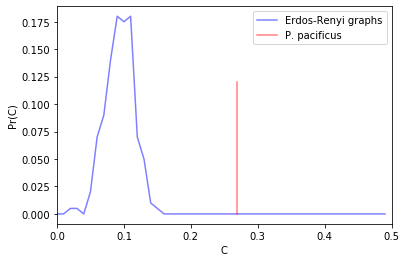

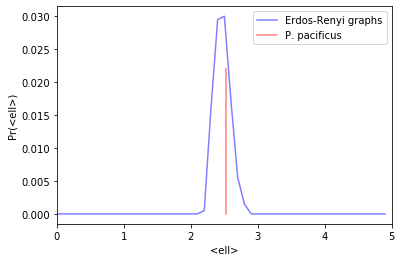

In [34]:
Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
##### do not modify above here #####

p = m / (np.math.factorial(n) / (np.math.factorial(2)*np.math.factorial(n-2)))
print(p)

for i in range(200):
    rG = nx.fast_gnp_random_graph(n, p)
    Cs.append(nx.transitivity(rG))
    ells.append(compute_MGD(rG))

##### do not modify below here #####
plot_nullAndEmpirical(Cs,C,'C','Erdos-Renyi graphs','P. pacificus',0.5,0.12)
plot_nullAndEmpirical(ells,ellmean,'<ell>','Erdos-Renyi graphs','P. pacificus',5,0.022)

While our distribution for the MGD is on par with the mean of that of P.pacificus, our ER random graphs produced a much lower-meaned distribution for the clustering coefficient. Which means that while the average path length required to traverse different nodes of the network is the same, there's a higher amount of triangle structure in the P. pacificus graph. 

### Problem 2-C (5 pts)

Before we use the `Chung-Lu random graph model` to assess whether the *P. pacificus* values of $C$ and $\langle \ell \rangle$ are large, small, typical, or unusual:
* Use the `expected_degree_graph()` function in `networkx` to take the degree sequence of the *P. pacificus* network and generate a single simple Chung-Lu graph $G$ with no self-loops.
* Then, create simple ridiculogram visualizations of this network and of the empirical *P. pacificus* network.
* For both, note the number of edges each graph contains.
* Comment briefly on what similarities or differences you observe between these two visualizations.

In [35]:
degree_seq = [val[1] for val in G.degree()]
rcG = nx.expected_degree_graph(degree_seq)

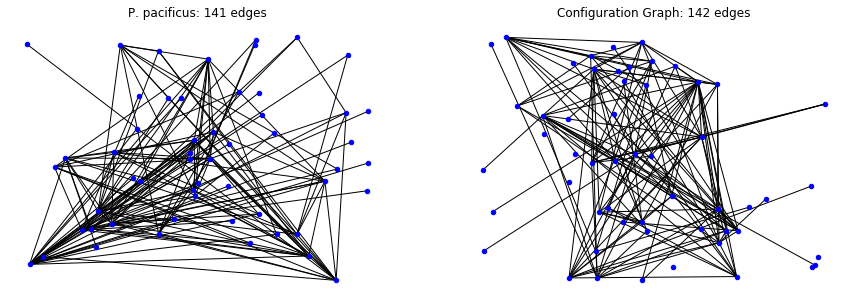

In [36]:
options = {
    'node_color': 'blue',
    'node_size': 20,
    'width': 1
}

f, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(121)
plt.title(f"P. pacificus: {len(G.edges)} edges")
nx.draw_random(G, **options)

plt.subplot(122)
plt.title(f"Configuration Graph: {len(rcG.edges)} edges")
nx.draw_random(rcG, **options)

plt.show()

I don't see any singletons in the P. pacificus graph, which is probably noteworthy. The number of edges looks very similar. This makes sense, since we have included a degree sequence, so this shouldn't really vary. The graphs really look very very similar to me, and it's hard to differentiate between them. 

### Problem 2-D (10 pts)

Now, write a wrapper around your Chung-Lu graph generator that replicates the work of your answer to `Problem 1-D`, and thereby assess whether the values of $C$ and $\langle \ell \rangle$ are large, small, typical, or unusual, given the *P. pacificus* degree structure. Specifically,
* using an appropriately parameterized Chung-Lu model, tabulate and plot
  * the Chung-Lu null distribution for $\Pr(C)$ and the empirical value of $C$
  * the Chung-Lu null distribution for $\Pr(\langle \ell \rangle)$ and the empirical value of $\langle \ell \rangle$
* briefly discuss how well the degree structure explains or fails to explain the empirical values, and how accounting for degree structure changes the null distributions

Hint: to get a good null distribution, 200 networks should be sufficient.

0.09853249475890985


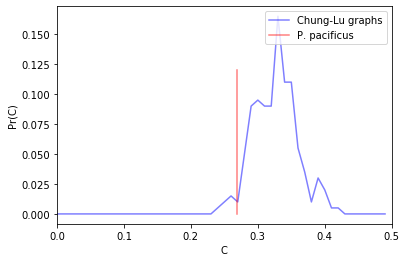

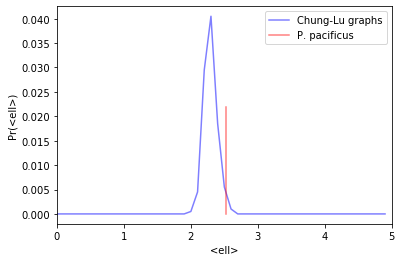

In [37]:
Cs   = []  # store the null values of C here
ells = []  # store the null values of ellmean here
##### do not modify above here #####


p = m / (np.math.factorial(n) / (np.math.factorial(2)*np.math.factorial(n-2)))
print(p)

degree_seq = [val[1] for val in G.degree()]

for i in range(200):
    rcG = nx.expected_degree_graph(degree_seq, selfloops=False)
    Cs.append(nx.transitivity(rcG))
    ells.append(compute_MGD(rcG))


##### do not modify below here #####
plot_nullAndEmpirical(Cs,C,'C','Chung-Lu graphs','P. pacificus',0.5,0.12)
plot_nullAndEmpirical(ells,ellmean,'<ell>','Chung-Lu graphs','P. pacificus',5,0.022)

Compared to our ER graph, we see a very massive increase in the distribution of $C$ values, and only a slight decrease in the $\ell$ distribution. The former, $C$, is without a doubt better represented by the Chung-Lu distribution, though it's still off. It's obvious enough at least that the clustering coefficient is better estimated with a known degree sequence, than with a constant edge probability throughout the network. It still doesn't really approximate the $\ell$ mean very well though, and so I'm wondering if there's a systematic nature to the graph of P. pacificus that works to minimize $\ell$ with a better-than-random chance. I think this is probably the case, and that it could be explained by general properties of learning and memory / synapse attenuation.

***
***

## Problem 3 : Reading the literature (*10 pts extra credit*)

*This extra credit problem is meant to help you look for a project topic*

Choose a paper from the [Supplemental Reading list on the external course webpage](https://aaronclauset.github.io/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

* *What paper did you choose?*<br/>
Give the Authors, Title, Publication Venue, Year
Brian Karrer and M. E. J. Newman, Random graphs containing arbitrary distributions of subgraphs, Physical Review, 2010
<br/>


* *What was the research question?*<br/>
The authors were pursuing a novel way to include the higher-than-expected motif prevelance (nontrivial densities of subgraphs) found in natural networks in a random graph model, while remaining "solvable", unlike some of the exponential random graph models that have been proposed in the past. They allege that they are only generalizing a form of random graph models that has been proposed in many specialized contexts in recent years. 
<br/>

* *What was the approach the authors took to answer that question?*<br/>
They begin by discussing the ER random graph model, and the principle that any particular subgraph can be expected to appear with a probability of $(\frac{c}{n})^{m_s}$, something we discussed briefly in class. The authors go on to discuss how the locally tree-like structure of the ER random graph is part of what makes deriving its properties possible, despite also being the root (hehe) cause of its lack of structure, moreso as you move outward from the large connected component. The authors suggest exploiting the tree-like structure at a higher level, "factor graph", and introducing any arbitrary subgraph distribution into the random model, while still preserving the solvable properties of the model.  
<br/>

Sorry, I wasn't able to get any further in my answers, and I've got to turn this in now! I'll try to allow myself more time in the future. Thanks! 

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here